In [1]:
!pip install genaibook
import datasets
import diffusers
import huggingface_hub

datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from diffusers import DDPMPipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# We load the dataset with images of birds.
from datasets import load_dataset
dataset = load_dataset("gjuggler/extra-birds", split="train")

# Print the features (columns) of the dataset
print(dataset.features)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

extra-birds.tar.gz:   0%|          | 0.00/8.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/293 [00:00<?, ? examples/s]

{'__key__': Value(dtype='string', id=None), '__url__': Value(dtype='string', id=None), 'jpg': Image(mode=None, decode=True, id=None)}


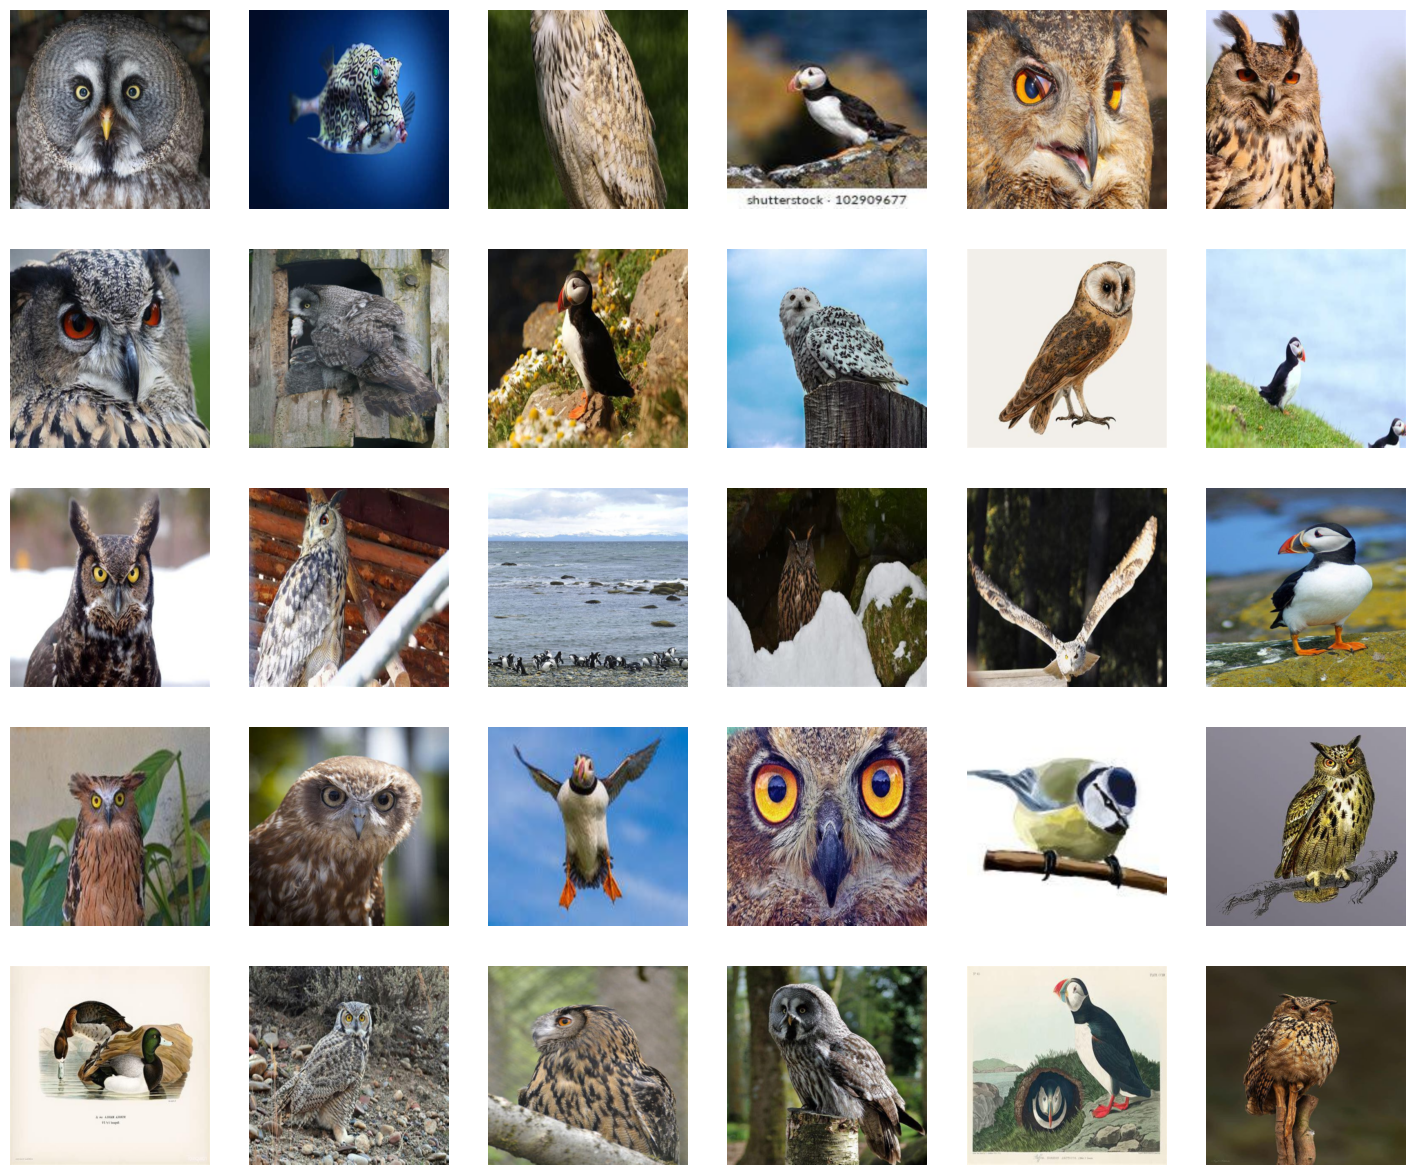

In [4]:
from genaibook.core import show_images
from torchvision import transforms
from PIL import Image
image_size = 384

# We apply transformations to the dataset
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # All images are resized
        transforms.RandomHorizontalFlip(),  # Randomly flip for data augmentation
        transforms.ToTensor(),  # Convert to PyTorch with pixel values [0, 1]
        transforms.Normalize([0.5], [0.5]),  # Pixel values are mapped from [0,1] to [-1, 1] to standardize the data
    ]
)

def transform(examples):
    """Take a batch of images from the dataset and applies the preprocessing pipeline."""
    # Assuming "jpg" column contains image objects, apply preprocessing directly
    examples = [preprocess(image) for image in examples["jpg"]]
    return {"images": examples}

dataset.set_transform(transform)  # Apply transformations to the dataset

# Create a dataloader
batch_size = 30
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

batch = next(iter(train_dataloader)) # load a batch of images

# Display the images
show_images(batch["images"][:30] * 0.5 + 0.5)

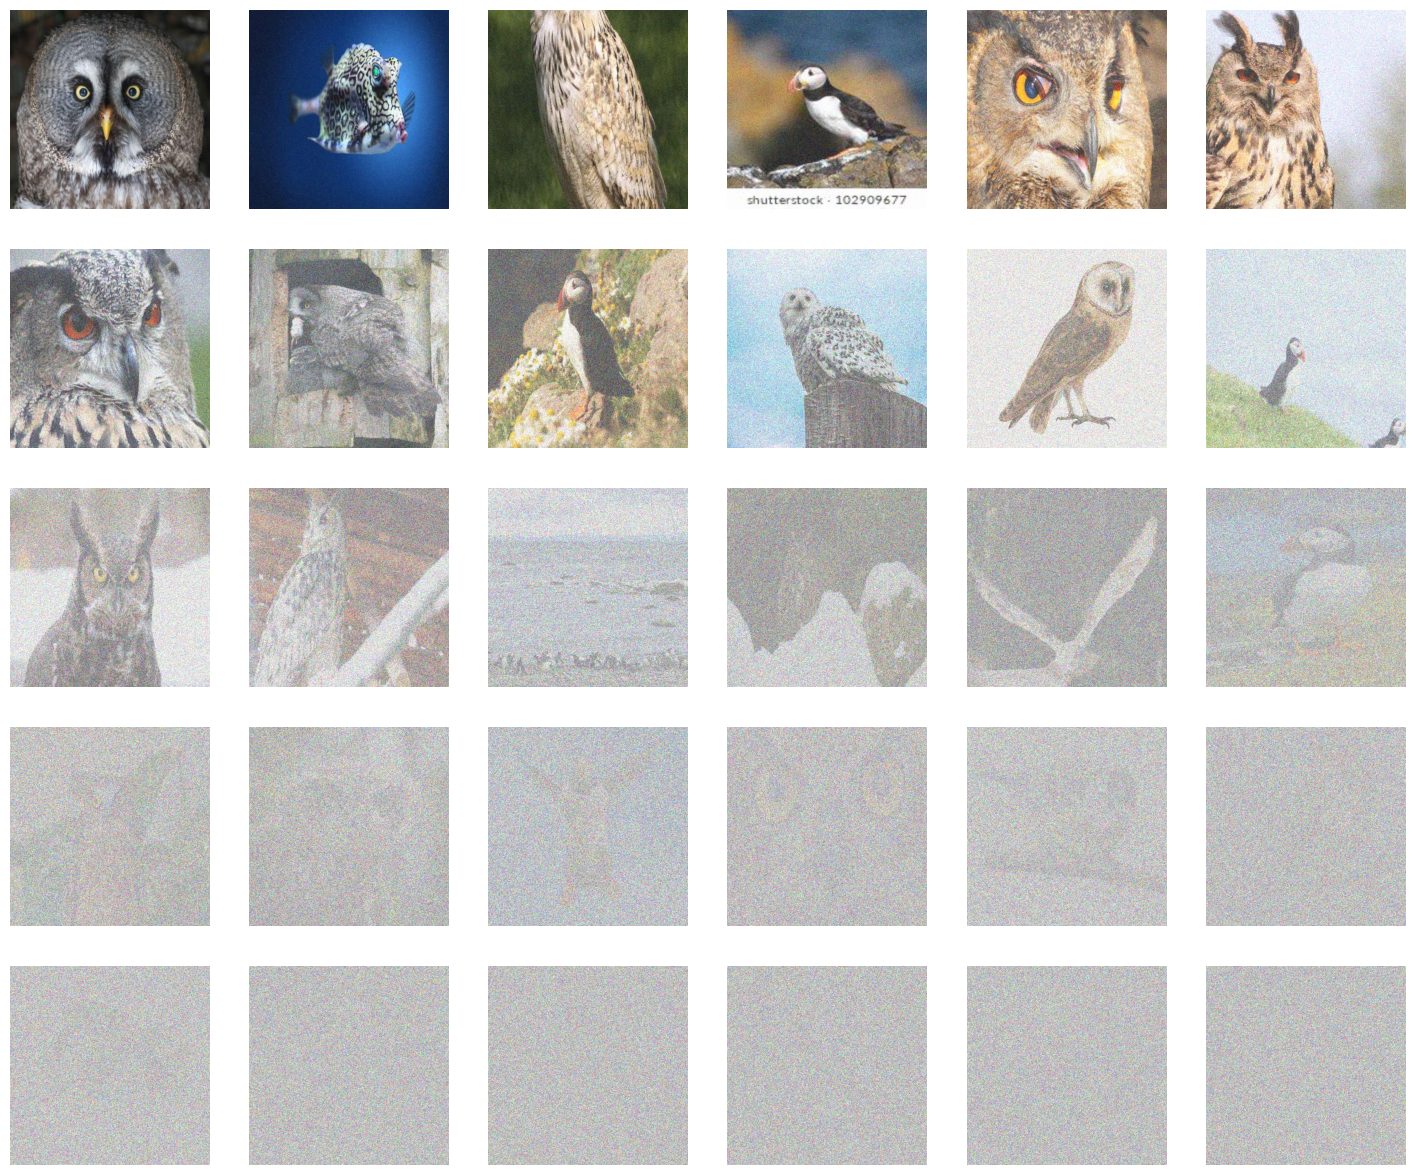

In [5]:
# Set Up the noise scheduler
from diffusers import DDPMScheduler

# Initialize the noise scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # Total number of noise steps
    beta_start=0.001,          # Starting noise level
    beta_end=0.02              # Ending noise level
)
# Create a tensor with 8 evenly spaced values from 0 to 999. These timesteps
# represent different stages of the noise-adding process.
timesteps = torch.linspace(0, 999, 30).long()

# Load 8 images from the dataset
x = batch["images"][:30]

# Generate random noise with the same shape as the images
noise = torch.rand_like(x)

# Add noise to images
noised_x = scheduler.add_noise(x, noise, timesteps) # Add noise to the images based on the timesteps

# Display the noisy images
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [6]:
from diffusers import UNet2DModel
# The UNet2DModel is imported from the diffusers library.
# This is a 2D U-Net model designed for image-based tasks like denoising.

# The UNet is a CNN invented for tasks such as image segmentation, where the desired output has the same shape as the input.
model = UNet2DModel(
    in_channels=3,  # Change to 3 to match RGB images
    sample_size=256,  # The input images are resized to 256x256 pixels
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to(device)

In [7]:
from torchvision import transforms
from torch.nn import functional as F
from datasets import load_dataset # Import load_dataset

# ##########################
# Set up data preprocessing
# ##########################
batch_size = 16 # Set batch size for training

# Define a function to preprocess images
def transform(examples):
    examples = [preprocess(image) for image in examples["jpg"]]
    return {"jpg": examples}

dataset.set_transform(transform) # Reset dataset to use the new preprocessing function
image_size = 256 # Set image size for resizing

# Define data augmentations and preprocessing steps
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert images to PyTorch tensors (range [0, 1])
        transforms.Normalize([0.5], [0.5]),  # Normalize to range [-1, 1]
    ]
)

# Create a DataLoader to load images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


# ##########################
# Set Up Training Parameters
# ##########################

# Training parameters
num_epochs = 150  # Number of times to loop through the dataset
lr = 1e-4  # Learning rate for the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Optimizer for training
losses = []  # List to store loss values for plotting


# ##########################
# Train the model
# ##########################

for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load clean images and move them to the device (e.g., GPU
        clean_images = batch["jpg"].to(device)

        # Generate random noise with the same shape as the clean images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample random timesteps for each image in the batch
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images based on the timesteps
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

         # Predict the noise using the model
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss between the predicted noise and the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later analysis
        losses.append(loss.item())

        ## Update the model parameters using backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Print the average loss for the epoch
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Finished epoch 0. Average loss for this epoch: 0.554871
Finished epoch 1. Average loss for this epoch: 0.154062
Finished epoch 2. Average loss for this epoch: 0.085032
Finished epoch 3. Average loss for this epoch: 0.068105
Finished epoch 4. Average loss for this epoch: 0.063332
Finished epoch 5. Average loss for this epoch: 0.052830
Finished epoch 6. Average loss for this epoch: 0.048936
Finished epoch 7. Average loss for this epoch: 0.048672
Finished epoch 8. Average loss for this epoch: 0.045449
Finished epoch 9. Average loss for this epoch: 0.039672
Finished epoch 10. Average loss for this epoch: 0.029673
Finished epoch 11. Average loss for this epoch: 0.033207
Finished epoch 12. Average loss for this epoch: 0.039140
Finished epoch 13. Average loss for this epoch: 0.036681
Finished epoch 14. Average loss for this epoch: 0.030332
Finished epoch 15. Average loss for this epoch: 0.025444
Finished epoch 16. Average loss for this epoch: 0.025976
Finished epoch 17. Average loss for this 

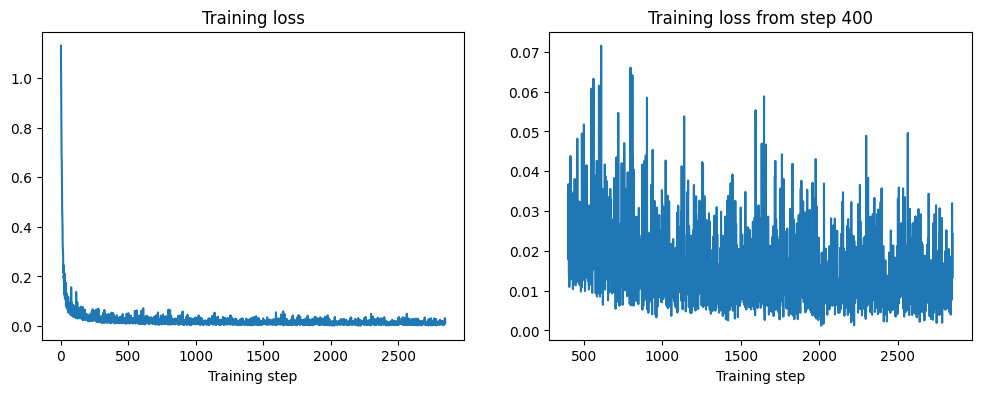

In [8]:
# We can now plot the training loss
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

<ipython-input-18-80d185afbf3f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animal_diffusion_model.pth"))


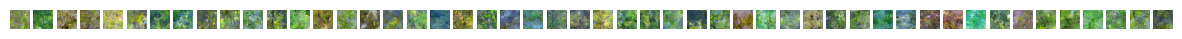

In [18]:
# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Function to generate images
def generate_images(num_images=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 256, 256)).to("cuda")  # Match input dimensions
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 50
generated_images = generate_images(num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

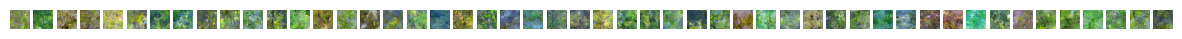

In [19]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [20]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'